The code below assumes that you have the images in this directory. to download images you can use the link shared. https://drive.google.com/drive/folders/1vz8jXuCJC8SBMewpA6BQybaS-GrDIeAI?usp=drive_link

## **<font color="#A41034">Setup Notebook</font>**

#### **Configuration**

In [4]:
## Global configuration settings to faciliate Colab and VM training
RUN_IN_VM = False
GET_IMAGES_FROM_GCSBUCKET_LEC8 = False
GET_IMAGES_FROM_GCSBUCKET_PROJ = True
USE_MOBILENET_AS_TEACHER = False
USE_VGG16_AS_TEACHER = True

#### **Installs**

In [2]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 26.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00


#### **Imports**

In [22]:
import argparse
import os
import requests
import zipfile
import tarfile
import shutil
import time
import json
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# fixer related
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Flatten, Dense
import scipy

# sklearn
from sklearn.model_selection import train_test_split

# Tensorflow Hub
import tensorflow_hub as hub

# W&B
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger

# cloud storage
from google.cloud import storage

#### **Argument Parser**

In [5]:
# Setup the arguments for the trainer task

if RUN_IN_VM:
  parser = argparse.ArgumentParser()
  parser.add_argument(
      "--model-dir", dest="model_dir", default="test", type=str, help="Model dir."
  )
  parser.add_argument("--lr", dest="lr", default=0.001, type=float, help="Learning rate.")
  parser.add_argument(
      "--model_name",
      dest="model_name",
      default="mobilenetv2",
      type=str,
      help="Model name",
  )
  parser.add_argument(
      "--train_base",
      dest="train_base",
      default=False,
      action="store_true",
      help="Train base or not",
  )
  parser.add_argument(
      "--epochs", dest="epochs", default=10, type=int, help="Number of epochs."
  )
  parser.add_argument(
      "--batch_size", dest="batch_size", default=16, type=int, help="Size of a batch."
  )
  parser.add_argument(
      "--wandb_key", dest="wandb_key", default="16", type=str, help="WandB API Key"
  )
  args = parser.parse_args()


#### **Model Parameters**

In [6]:
## other parameters
img_height = 224
img_width  = 224
img_channel = 3                 ## imagenet is trained on RGB
num_classes = 2

if RUN_IN_VM:
  ## for running in VM
  model_name = args.model_name
  train_base = args.train_base
  learning_rate = args.lr
  batch_size = args.batch_size
  epochs = args.epochs
else:
  ## for running in local Colab
  model_name = "vgg16_train_base"
  train_base = True
  learning_rate = 0.001
  batch_size = 32
  epochs = 5

#### **Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [7]:
# TF Version
print("tensorflow version", tf.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())
# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices("GPU"))

print("GPU Available: ", tf.config.list_physical_devices("GPU"))
print("All Physical Devices", tf.config.list_physical_devices())



tensorflow version 2.12.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
GPU Available:  []
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


#### **Utils**

Here are some util functions that are used for this notebook
* progressbar()
* get_model_size()
* JsonEncoder
* save_model()
* evaluate_model()
* parse_tfrecord_example()
* normalize()
* create_dataset()

In [8]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress

    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.

    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::

        for i in range(n_iterations):
            progressbar(i, n_iterations)

    .. source:

        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """

    import sys                                                     ## import this library to stdio

    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [9]:
def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".hdf5")).st_size
  return model_size


In [10]:
class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

In [11]:
experiment_name = "models"
def save_model(model,model_train_history,execution_time, learning_rate, epochs, optimizer, evaluation_results):
  model_name=model.name

  # Ensure path exists
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)
  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

  model_size = get_model_size(model_name=model.name)

  # Save model history
  with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
      json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

  trainable_parameters = count_params(model.trainable_weights)
  non_trainable_parameters = count_params(model.non_trainable_weights)

  # Save model metrics
  metrics ={
      "trainable_parameters":trainable_parameters,
      "execution_time":execution_time,
      "loss":evaluation_results[0],
      "accuracy":evaluation_results[1],
      "model_size":model_size,
      "learning_rate":learning_rate,
      "batch_size":batch_size,
      "epochs":epochs,
      "optimizer":type(optimizer).__name__
  }
  with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
      json_file.write(json.dumps(metrics,cls=JsonEncoder))


In [12]:
def evaluate_model(model,test_data, model_train_history,execution_time,
                        learning_rate, batch_size, epochs, optimizer,
                        save=True,
                        loss_metrics=["loss","val_loss"],
                        acc_metrics=["accuracy","val_accuracy"]):

  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history[loss_metrics[0]])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in loss_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in acc_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()

  # Evaluate on test data
  evaluation_results = model.evaluate(test_data, return_dict=True)
  print(evaluation_results)

  evaluation_results = [evaluation_results[loss_metrics[0]], evaluation_results[acc_metrics[0]]]

  if save:
    # Save model
    save_model(model, model_train_history,execution_time, learning_rate, epochs, optimizer, evaluation_results)

  return evaluation_results

In [38]:
## this function parses each photo and defines the size of the image and the label
## It is used in the create_dataset() function

# @tf.function
def parse_tfrecord_example(example_proto):

  # Read TF Records
  feature_description = {
      'image': tf.io.FixedLenFeature([], tf.string),
      'label': tf.io.FixedLenFeature([], tf.int64)
  }

  parsed_example = tf.io.parse_single_example(example_proto, feature_description)

  # Image
  # image = tf.image.decode_jpeg(parsed_example['image'])
  image = tf.io.decode_raw(parsed_example['image'], tf.uint8)
  image.set_shape([img_channel * img_height * img_width])
  image = tf.reshape(image, [img_height, img_width, img_channel])
  # Label
  label = tf.cast(parsed_example['label'], tf.int32)
  #label = tf.one_hot(label, num_classes)

  return image, label

In [39]:
## this function normalizes the pixels in the image
## it is used in the create_dataset() function

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

In [40]:
# This function creates the tf-records prefetch object
# you can specify which tf-records to pull from, thus creating your train, val, test sets

def create_dataset(batch_size,
                   num_channels,
                   image_height,
                   image_width,
                   num_classes,
                   records_dir,
                   prefix):

  # Read the tfrecord files
  tfrecord_files = tf.data.Dataset.list_files(records_dir + prefix)

  #############
  # Train data
  #############
  data = tfrecord_files.flat_map(tf.data.TFRecordDataset)
  data = data.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
  data = data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
  data = data.batch(batch_size)
  data = data.prefetch(buffer_size=tf.data.AUTOTUNE)

  return data


## **<font color="#A41034">Real Estate (Fixer vs Renovated) Image Dataset</font>**

#### **Download dataset from GCS bucket (Lect8_bucket)**



In [ ]:
## download dataset from GCS bucket
if GET_IMAGES_FROM_GCSBUCKET_LEC8:
  from google.cloud import storage
  storage_client = storage.Client()                    # Initialize the Google Cloud Storage client

  def download_folder_from_gcs(bucket_name, source_folder_path, destination_folder_path):
      """
      Downloads a folder from Google Cloud Storage to a local directory.

      :param bucket_name: Name of the GCS bucket.
      :param source_folder_path: Path in GCS of the folder you want to download.
      :param destination_folder_path: Local path where the folder should be downloaded.
      """

      # Initialize the GCS client
      #storage_client = storage.Client.from_service_account_json(path_to_secret_key)
      bucket = storage_client.bucket(bucket_name)

      # Get the list of files from the source folder path in GCS
      blobs = bucket.list_blobs(prefix=source_folder_path)

      for blob in blobs:
          # Check if the blob is a directory itself
          if not blob.name.endswith('/'):
              # Construct the full local path
              local_file_path = os.path.join(destination_folder_path, os.path.relpath(blob.name, source_folder_path))
              local_dir = os.path.dirname(local_file_path)

              # Create local directories if they don't exist
              if not os.path.exists(local_dir):
                  os.makedirs(local_dir)

              # Download the file
              blob.download_to_filename(local_file_path)
              print(f"File {blob.name} downloaded to {local_file_path}.")



#### **Read in images from Bucket (lec8_bucket)**

In [ ]:
## bucket_name is the bucket you are donwloading from.
## prefix is the folder you want to download from.
## the last arguement is which folder you want things downloaded into.
## download_folder_from_gcs(bucket_name, prefix_fixers, 'fixers_download_from_gcs')

if GET_IMAGES_FROM_GCSBUCKET_LEC8:
  bucket_name='lec8_bucket'
  download_folder_from_gcs(bucket_name, 'craigslist images/fixer_uppers/', 'fixers_download_from_gcs')
  download_folder_from_gcs(bucket_name, 'craigslist images/renovated/', 'renovated_download_from_gcs')


In [ ]:
## folder as destination of images. These images will be used for model training

if GET_IMAGES_FROM_GCSBUCKET_LEC8:
  dest_renovated   = 'renovated_download_from_gcs'
  dest_fixer_upper = 'fixers_download_from_gcs'

#### **Load Data**

* Read-in data as lists
* Each element in data_x is the path to the image
* Each element in data_y is the label of that image

#### **Combine class (fixer) & class (renovated) as data_list. Create labels**

In [ ]:
## create 2 lists: renovated_images, fixer_images
if GET_IMAGES_FROM_GCSBUCKET_LEC8:
  renovated_images = []
  for root, dirs, files in os.walk(dest_renovated):
      for file in files:
          # ensure file is an image
          if file.lower().endswith(('.png', '.jpg', '.jpeg')):
              renovated_images.append(os.path.join(root, file))

  fixer_images = []
  for root, dirs, files in os.walk(dest_fixer_upper):
      for file in files:
          # ensure file is an image
          if file.lower().endswith(('.png', '.jpg', '.jpeg')):
              fixer_images.append(os.path.join(root, file))

In [ ]:
# Generate a list of labels and full paths to images
if GET_IMAGES_FROM_GCSBUCKET_LEC8:
  data_list = []
  for label,prop_type in enumerate(['fixer','renovated']):
    if prop_type == 'fixer':
      data_list.extend([(label,f) for f in fixer_images])
    elif prop_type == 'renovated':
      data_list.extend([(label,f) for f in renovated_images])

  ## sanity check
  print("Full size of the dataset:",len(data_list))
  print("data_list (fixer):",data_list[0:2])
  print("data_list (renovated):",data_list[-2:])


Full size of the dataset: 3000
data_list (fixer): [(0, 'small_fixer_upper/7666371376/image_3.jpg'), (0, 'small_fixer_upper/7666371376/image_11.jpg')]
data_list (renovated): [(1, 'small_renovated/7660137400/image_2.jpg'), (1, 'small_renovated/7660137400/image_1.jpg')]


#### **Randomly inspect some input images**

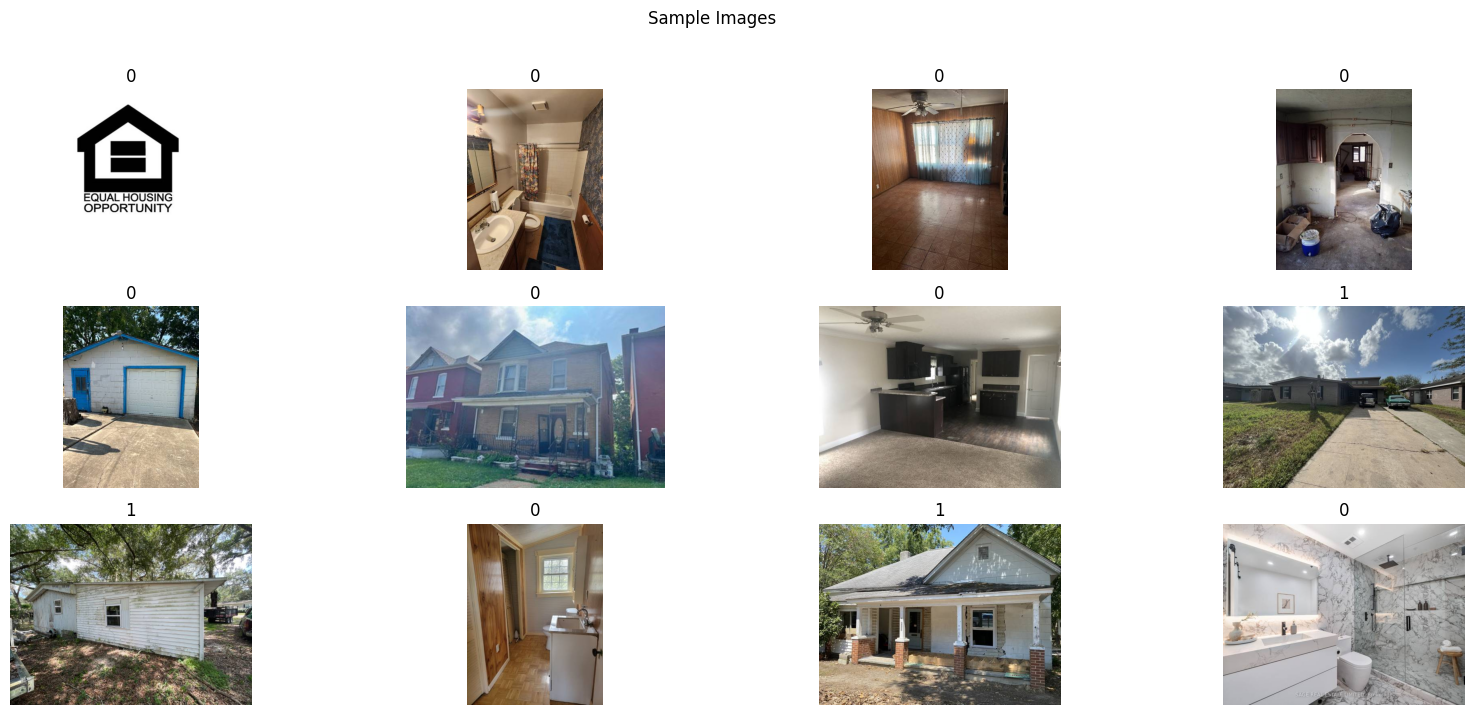

In [ ]:
if not RUN_IN_VM:
  # Generate a random sample of index
  import numpy as np

  # Generate a random sample of index
  image_samples = np.random.randint(0,high=len(data_list)-1, size=12)

  fig = plt.figure(figsize=(20,8))
  for i,img_idx in enumerate(image_samples):
      axs = fig.add_subplot(3,4,i+1)
      axs.set_title(data_list[img_idx][0])
      # Read image
      image = plt.imread(data_list[img_idx][1])

      plt.imshow(image);
      plt.axis('off')

  plt.suptitle("Sample Images")
  plt.show()


#### **Generate data_x & data_y**

In [ ]:
## to generate data_x & data_y
if GET_IMAGES_FROM_GCSBUCKET_LEC8:
  # Build data x, y
  data_x = [itm[1] for itm in data_list]
  data_y = [itm[0] for itm in data_list]

  # sanity check

  print("data_x:",len(data_x))
  print("data_y:",len(data_y))
  print("data_x:",data_x[:5])
  print("data_y:",data_y[:5])


data_x: 3000
data_y: 3000
data_x: ['small_fixer_upper/7666371376/image_3.jpg', 'small_fixer_upper/7666371376/image_11.jpg', 'small_fixer_upper/7666371376/image_7.jpg', 'small_fixer_upper/7666371376/image_20.jpg', 'small_fixer_upper/7666371376/image_23.jpg']
data_y: [0, 0, 0, 0, 0]


## **<font color="#A41034">Build the data pipeline</font>**

#### **Split the Data**

In [ ]:
## Train_test_split()
if GET_IMAGES_FROM_GCSBUCKET_LEC8:
  test_percent = 0.10
  validation_percent = 0.2

  # Split data into train / test
  train_validate_x, test_x, train_validate_y, test_y = train_test_split(data_x,
                                                                        data_y,
                                                                        test_size=test_percent)

  # Split data into train / validate
  train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x,
                                                            train_validate_y,
                                                            test_size=test_percent)


In [ ]:
## sanity check
if GET_IMAGES_FROM_GCSBUCKET_LEC8:
  print("train_x count:",len(train_x))
  print("validate_x count:",len(validate_x))
  print("test_x count:",len(test_x))


train_x count: 2430
validate_x count: 270
test_x count: 300


#### **create TF Data**

In [ ]:
## To create TF datasets
if GET_IMAGES_FROM_GCSBUCKET_LEC8:
  def get_dataset(image_width = 224, image_height = 224, num_channels = 3, batch_size = 32):

    # Load Image
    def load_image(path, label):
      image = tf.io.read_file(path)
      image = tf.image.decode_jpeg(image, channels=num_channels)
      image = tf.image.resize(image, [image_height,image_width])
      return image, label

    # Normalize pixels
    def normalize(image, label):
      image = image/255
      return image, label

    train_shuffle_buffer_size= len(train_x)
    validation_shuffle_buffer_size= len(validate_x)

    # Create TF Dataset
    train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
    validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_y))
    test_data = tf.data.Dataset.from_tensor_slices((test_x, test_y))

    #############
    # Train data
    #############
    # Apply all data processing logic
    train_data = train_data.cache()\
                          .shuffle(buffer_size=train_shuffle_buffer_size)\
                          .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
                          .batch(batch_size)\
                          .prefetch(tf.data.AUTOTUNE)\

    ##################
    # Validation data
    ##################
    # Apply all data processing logic
    validation_data = validation_data.cache()\
                          .shuffle(buffer_size=validation_shuffle_buffer_size)\
                          .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
                          .batch(batch_size)\
                          .prefetch(tf.data.AUTOTUNE)\

    ############
    # Test data
    ############
    # Apply all data processing logic
    test_data = test_data.cache()\
                          .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
                          .batch(batch_size)\
                          .prefetch(tf.data.AUTOTUNE)\

    return (
        train_data, validation_data, test_data
    )

#### **Download TF Records from Project Bucket**

In [41]:
# Define these variables before running function
if RUN_IN_VM:
  ## run in VM
  local_dir = './tf-records'
  secrets_json = './secrets/gcp-rehab-ai-secret.json'
  records_dir = './tf-records'           ## directory where the tf-records are pulling from
else:
  ## run in local colab
  local_dir = '/content/tf-records'
  secrets_json = '/content/secrets/gcp-rehab-ai-secret.json'
  records_dir = '/content/tf-records'       ## directory where the tf-records are pulling from

gcp_dir = 'tf-records'
bucket_name = "rehab-image-detection-data"

In [42]:
## download the TF Records from project GCS bucket
def download_TFRecords(gcp_dir,
                       local_dir,
                       secrets_json,
                       bucket_name):
    print("downloading")

    # Clear
    #shutil.rmtree(input_images, ignore_errors=True, onerror=None)
    #makedirs()

    if not RUN_IN_VM:
      storage_client = storage.Client.from_service_account_json(secrets_json)
    else:
      storage_client = storage.Client()                    # Initialize the Google Cloud Storage client
    bucket = storage_client.get_bucket(bucket_name)

    blobs = bucket.list_blobs(prefix=gcp_dir + "/")

    for blob in blobs:
        if not blob.name.endswith("/"):
            filename = str(blob.name)
            filename = filename.replace(gcp_dir,"")
            destination_path = local_dir + filename
            blob.download_to_filename(destination_path)

    print("finished downloading")

In [43]:
## Before downloading you must create destination directory to store the tf-records
tfrecords_output_dir = "tf-records"
if os.path.exists(tfrecords_output_dir):
  shutil.rmtree(tfrecords_output_dir)
tf.io.gfile.makedirs(tfrecords_output_dir)

In [44]:
## Download TF records
download_TFRecords(gcp_dir=gcp_dir,
                   local_dir=local_dir,
                   secrets_json=secrets_json,
                   bucket_name=bucket_name)

downloading
finished downloading


#### **create datasets from TF Records (train_data, validation_data, test_data)**

In [46]:
## prepare the train data

# Defines which tfrecords to pull. Change to '/train*' to get all train tf-records
prefix = '/train_0000.tfrecords'

train_data = create_dataset(batch_size=batch_size,
                   num_channels=img_channel,
                   image_height=img_height,
                   image_width=img_width,
                   num_classes=num_classes,
                   records_dir=records_dir,
                   prefix=prefix)

In [47]:
## prepare the validation data

# Defines which tfrecords to pull. Change prefix to '/val*' to get all val tf-records
prefix = '/val_0000.tfrecords'

validation_data = create_dataset(batch_size=batch_size,
                   num_channels=img_channel,
                   image_height=img_height,
                   image_width=img_width,
                   num_classes=num_classes,
                   records_dir=records_dir,
                   prefix=prefix)

In [48]:

## prepare the test data

# Defines which tfrecords to pull. Change to '/test*' to get all test tf-records
prefix = '/test_0000.tfrecords'

test_data = create_dataset(batch_size=batch_size,
                   num_channels=img_channel,
                   image_height=img_height,
                   image_width=img_width,
                   num_classes=num_classes,
                   records_dir=records_dir,
                   prefix=prefix)

In [34]:
## sanity check
print("===== sanity check (train_data, val_data, test_data) =====")
print(train_data)
print(validation_data)
print(test_data)

===== sanity check (train_data, val_data, test_data) =====
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


## **<font color="#A41034">Authenticate login to WandB</font>**

In [35]:
## to relogin as a different user, for example switching to team project authentication
# !wandb login --relogin

In [49]:
## # Login to W&B account
if RUN_IN_VM:
  wandb.login(key=args.wandb_key)
else:
  wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


## **<font color="#A41034">Teacher Model (vgg16) with wandb callback and using TF data as input</font>**

In [50]:
## train & save weights into wandb.ai

## transfer learning from keras VGG16 model weights

# Free up memory
K.clear_session()

# Data
# train_data, validation_data, test_data = get_dataset(image_width = img_width,
#                                                      image_height = img_height,
#                                                      num_channels = img_channel,
#                                                      batch_size = batch_size)
if USE_VGG16_AS_TEACHER:
  # invoke VGG16
  new_input = Input(shape=(img_height, img_width, img_channel))
  base_model = VGG16(weights='imagenet', input_tensor=new_input, include_top=False)
  base_model.summary()

  # base layers + 3 FC layers
  x = Flatten()(base_model.layers[-1].output)

  # Add a fully connected layer with 1024 units and ReLU activation
  x = Dense(units=1024, activation='relu')(x)
  x = Dense(units=1024, activation='relu')(x)
  x = Dense(units=1024, activation='relu')(x)

  # Add a final output layer with the desired number of classes and sigmoid activation
  output = Dense(units=1, activation='sigmoid')(x)

  # Create the final model by combining the VGG16 base model with the newly added layers
  teacher_model = Model(inputs=base_model.input, outputs=output, name=model_name+'_'+str(train_base))

  # fix all weights in base_model
  for layer in base_model.layers:
      layer.trainable = False

  # Compile the model with appropriate loss, optimizer, and metrics
  teacher_model.compile(optimizer = Adam(),
                      loss = 'binary_crossentropy',
                      metrics = ['acc'])

  # Initialize a W&B run
  wandb.init(
      project = 'rehab-ai-main',
      config = {
        "learning_rate": learning_rate,
        "epochs": epochs,
        "batch_size": batch_size,
        "model_name": teacher_model.name
      },
      name = teacher_model.name
  )

  # Train the model on the training data and validate on the validation data
  start_time = time.time()
  history = teacher_model.fit(train_data,
                            validation_data=validation_data,
                            callbacks=[WandbCallback()],
                            verbose=1,
                            epochs=epochs)

  execution_time = (time.time() - start_time)/60.0
  print("Training execution time (mins)",execution_time)

  # Update W&B
  wandb.config.update({"execution_time": execution_time})

  # Close the W&B run
  wandb.run.finish()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Epoch 1/5
     90/Unknown - 102s 1s/step - loss: 0.8531 - acc: 0.6128

wandb: Adding directory to artifact (/content/wandb/run-20231025_212846-osel61g2/files/model-best)... Done. 2.0s


90/90 [==============================] - 167s 2s/step - loss: 0.8531 - acc: 0.6128 - val_loss: 0.5635 - val_acc: 0.6996
Epoch 2/5
90/90 [==============================] - 158s 2s/step - loss: 0.5213 - acc: 0.7333 - val_loss: 0.5968 - val_acc: 0.6852
Epoch 3/5
90/90 [==============================] - 168s 2s/step - loss: 0.4317 - acc: 0.7969 - val_loss: 0.6020 - val_acc: 0.7246
Epoch 4/5
90/90 [==============================] - 166s 2s/step - loss: 0.3414 - acc: 0.8490 - val_loss: 1.0179 - val_acc: 0.7135
Epoch 5/5
90/90 [==============================] - 158s 2s/step - loss: 0.3376 - acc: 0.8497 - val_loss: 0.6194 - val_acc: 0.7246
Training execution time (mins) 13.614960463841756


acc,▁▅▆██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_acc,▄▁█▆█
val_loss,▁▂▂█▂
acc,0.84965
best_epoch,0
best_val_loss,0.56352
epoch,4
loss,0.33765
val_acc,0.7246


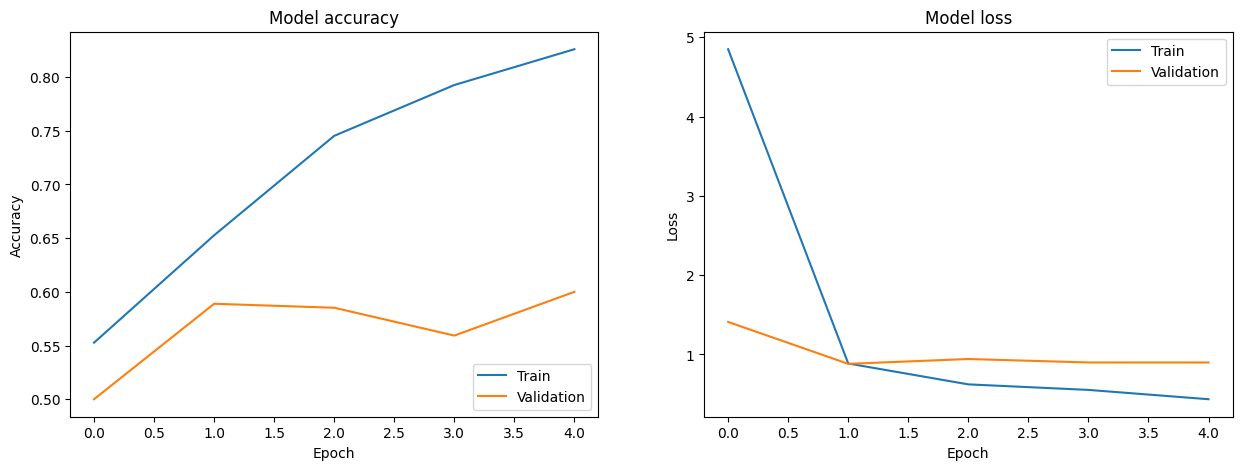

In [ ]:
# ploting results loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Plotting accuracy
axs[0].plot(history.history['acc'])
axs[0].plot(history.history['val_acc'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='lower right')
# Plot loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')
plt.show()

## **<font color="#A41034">Teacher Model (mobilenet_v2) from tfhub.</font>**

#### **Build Teacher Model**

In [ ]:
if USE_MOBILENET_AS_TEACHER:

  def build_teacher_model(image_height, image_width, num_channels, num_classes):

    # Model input
    input_shape = [image_height, image_width, num_channels] # height, width, channels

    # Handle to pretrained model (Use a different model here)
    handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

    # Regularize using L1
    kernel_weight = 0.02
    bias_weight = 0.02

    model = Sequential([
          keras.layers.InputLayer(input_shape=input_shape),
                                  hub.KerasLayer(handle, trainable=False),
          keras.layers.Dense(units=64, activation='relu',
                            kernel_regularizer=keras.regularizers.l1(kernel_weight),
                            bias_regularizer=keras.regularizers.l1(bias_weight)
                            ),
          keras.layers.Dense(units=num_classes-1,
                            kernel_regularizer=keras.regularizers.l1(kernel_weight),
                            bias_regularizer=keras.regularizers.l1(bias_weight)),
    ],name='teacher_model')

    return model

#### **Train Teacher**

In [ ]:
############################
# Training Params
############################

if USE_MOBILENET_AS_TEACHER:
  learning_rate = 0.001
  initial_epoch = 0
  epochs = 500

  # Load pre trained model during demos
  LOAD_PREV_TRAINED = False

  # Free up memory
  K.clear_session()

  # Optimizer
  optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
  # Loss
  #loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  loss = keras.losses.BinaryCrossentropy(from_logits=True)

  # Build or Load Model
  if not LOAD_PREV_TRAINED:
    # Build the teacher model
    teacher_model = build_teacher_model(img_height, img_width, num_channels, num_classes)
    print(teacher_model.summary())

    # Compile
    teacher_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=[keras.metrics.BinaryAccuracy()])
                        # metrics=[keras.metrics.SparseCategoricalAccuracy()])

  else:
    # Load model
    teacher_model = keras.models.load_model("distil_models/teacher_model.hdf5", custom_objects={'KerasLayer':hub.KerasLayer})
    print(teacher_model.summary())


    with open("distil_models/teacher_model_train_history.json") as json_file:
      prev_training_history = json.load(json_file)
    with open("distil_models/teacher_model_model_metrics.json") as json_file:
      model_metrics = json.load(json_file)

    epochs = len(prev_training_history["loss"])
    initial_epoch=epochs
    epochs=epochs+3 # Continue training for a few more epochs


  # Train model
  start_time = time.time()
  training_results = teacher_model.fit(
          train_data,
          validation_data=validation_data,
          epochs=epochs,
          initial_epoch=initial_epoch,
          verbose=1)
  execution_time = (time.time() - start_time)/60.0
  print("Training execution time (mins)",execution_time)

  # Get model training history
  training_history = training_results.history

  if LOAD_PREV_TRAINED:
    # Append previous training history & time
    training_history = append_training_history(training_results.history,
                                              prev_training_history,
                                              metrics=["loss","val_loss","binary_accuracy","val_binary_accuracy"])
    execution_time = model_metrics["execution_time"] + execution_time

  # Evaluate model
  evaluate_model(teacher_model,validation_data, training_history,execution_time,
                      learning_rate, batch_size, epochs, optimizer,
                      save=True,
                      loss_metrics=["loss","val_loss"],
                      acc_metrics=["binary_accuracy","val_binary_accuracy"])
                      #acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

## **<font color="#A41034">Build Student Model</font>**

#### **Student Model**
* 2 conv layers with max pooling and 1 dense layer

In [57]:
def build_student_model(image_height, image_width, num_channels, num_classes, model_name='student'):
  # Model input
  input_shape = [image_height, image_width, num_channels]  # height, width, channels

  model = Sequential(
      [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding="same",
                            kernel_initializer=keras.initializers.GlorotUniform(seed=1212)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same",
                            kernel_initializer=keras.initializers.GlorotUniform(seed=2121)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        keras.layers.Flatten(),
        # keras.layers.Dense(units=32, kernel_initializer=keras.initializers.GlorotUniform(seed=2323)),
        #keras.layers.Dense(units=num_classes, kernel_initializer=keras.initializers.GlorotUniform(seed=3434))
        keras.layers.Dense(units=num_classes-1, kernel_initializer=keras.initializers.GlorotUniform(seed=3434))
      ],
      name=model_name)

  return model

#### **Train the Student model**
* 2 conv layers with max pooling and 1 dense layer
* for comparison purpose (pre-distillation)

Model: "student_scratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                               

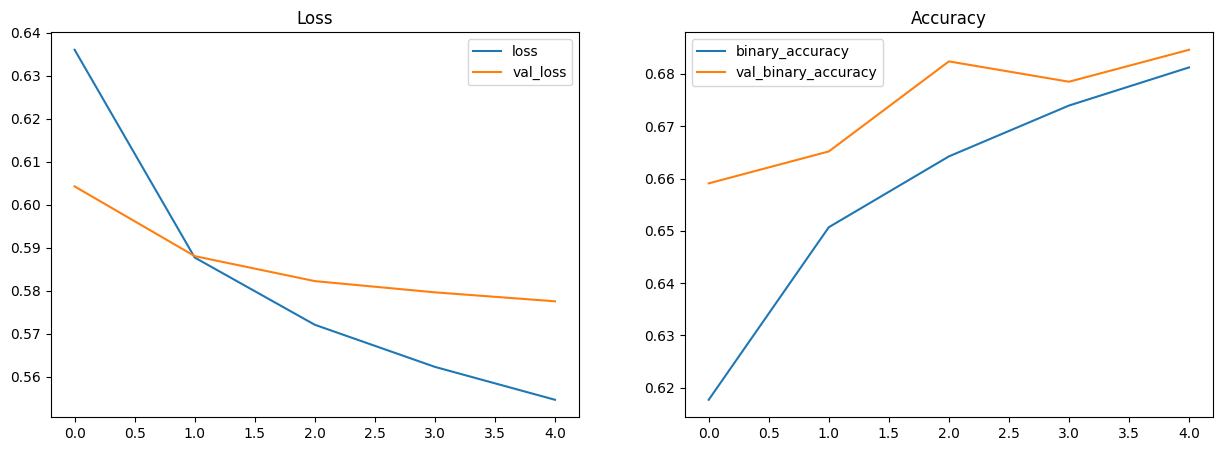

57/57 [==============================] - 1s 9ms/step - loss: 0.5775 - binary_accuracy: 0.6846
{'loss': 0.5775446891784668, 'binary_accuracy': 0.684619665145874}


[0.5775446891784668, 0.684619665145874]

In [58]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 5

# Free up memory
K.clear_session()

# Build the model
student_model_scratch = build_student_model(img_height, img_width, img_channel, 2, model_name='student_scratch')
print(student_model_scratch.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.BinaryCrossentropy(from_logits=True)

# Compile
student_model_scratch.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.BinaryAccuracy()])

# Train teacher model
start_time = time.time()
training_results = student_model_scratch.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluate_model(student_model_scratch,validation_data, training_history,execution_time,
                    learning_rate, batch_size, epochs, optimizer,
                    save=True,
                    loss_metrics=["loss","val_loss"],
                    acc_metrics=["binary_accuracy","val_binary_accuracy"])



## **<font color="#A41034">Build Distiller</font>**

#### **Class definition**
**Distiller(Model)**
* **attribute:** Lambda, temperature
* **method:** compile(), train_step(), test_step()

In [59]:
class Distiller(Model):
    def __init__(self, teacher, student):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, Lambda = 0.1, temperature=3):
      """
      optimizer: Keras optimizer for the student weights
      metrics: Keras metrics for evaluation
      student_loss_fn: Loss function of difference between student predictions and ground-truth
      distillation_loss_fn: Loss function of difference between soft student predictions and soft teacher predictions
      lambda: weight to student_loss_fn and 1-alpha to distillation_loss_fn
      temperature: Temperature for softening probability distributions. Larger temperature gives softer distributions.
      """
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn

      #hyper-parameters
      self.Lambda = Lambda
      self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher (professor)
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.Lambda * student_loss + (1 - self.Lambda) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

#### **Knowlege distillation - plain (from teacher to student)**
* matching teacher output (prob) to student output (prob)

Model: "student_distill"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                               

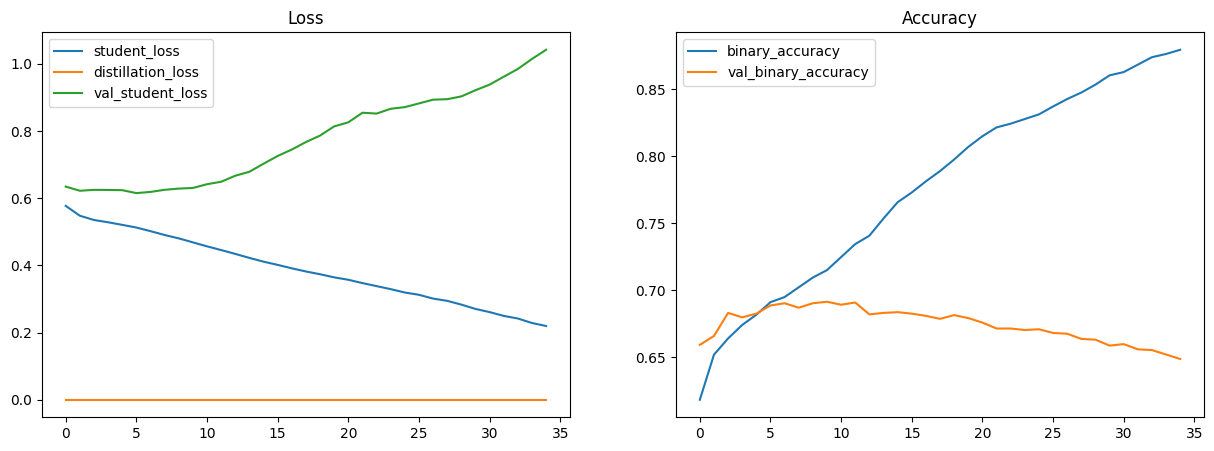

57/57 [==============================] - 1s 8ms/step - binary_accuracy: 0.6485 - student_loss: 0.9062


{'binary_accuracy': 0.6485285758972168, 'student_loss': 1.0420595407485962}


In [60]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 35
Lambda = 0.75
#temperature= 12
temperature= 20

# Free up memory
K.clear_session()

# Build Student model
student_model = build_student_model(img_height, img_width, img_channel, 2, model_name='student_distill')
print(student_model.summary())

# Build the distiller model
distiller_model = Distiller(teacher=teacher_model, student=student_model)

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
student_loss = keras.losses.BinaryCrossentropy(from_logits=True)

#distillation_loss = keras.losses.KLDivergence()
distillation_loss = keras.losses.BinaryCrossentropy(from_logits=False)

# Compile
distiller_model.compile(
    optimizer=optimizer,
    student_loss_fn=student_loss,
    distillation_loss_fn=distillation_loss,
    metrics=[keras.metrics.BinaryAccuracy()],
    Lambda=Lambda,
    temperature=temperature
)

# Distill teacher to student
start_time = time.time()
training_results = distiller_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluation_results = evaluate_model(distiller_model,validation_data,
               training_history,execution_time,learning_rate, batch_size, epochs, optimizer,
               save=False,
               loss_metrics=["student_loss","distillation_loss","val_student_loss"],
               acc_metrics=["binary_accuracy","val_binary_accuracy"])

# Save student model


save_model(student_model,training_history,execution_time,learning_rate, epochs, optimizer, evaluation_results)

## **<font color="#A41034">Other flavors of Distillation</font>**

#### **Knowlege distillation - online distillation (2  students)**
* no teacher, 2 students, matching output (prob)

#### **Knowlege distillation - online distillation (3  students)**
* no teacher, 3 students, matching output (prob)

#### **Knowlege distillation - Self Distillation**
* 1st iteration: 1 teacher + 1 student, matching output (prob)
* 2nd iteration and onwards: 1 student only

## **<font color="#A41034">Compare All Models</font>**

In [63]:
models_folder = "models" # distil_models / models
models_metrics_list = glob(models_folder+"/*_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace(models_folder+"/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.3f} MB'.format)

view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head()

,trainable_parameters,execution_time,loss,accuracy,model_size,learning_rate,batch_size,epochs,optimizer,name
1,"4,529",0.19 mins,0.58,68.46%,0.096 MB,0.001,32,5,Adam,student_scratch
0,"4,529",54.18 mins,1.04,64.85%,0.040 MB,0.001,32,35,Adam,student_distill


## **<font color="#A41034">template</font>**

#### **Utils**

Here are some util functions that we will be using for this notebook

#### **Utils**

Here are some util functions that we will be using for this notebook

## **<font color="#A41034">template</font>**

#### **Utils**

Here are some util functions that we will be using for this notebook

#### **Utils**

Here are some util functions that we will be using for this notebook